# 1. Entendimiento del Negocio

## 1.1 Objetivo del Análisis

Realizar un diagnóstico general de la base de datos y encontrar la respuesta a las siguientes preguntas:

1. Desarrollar y mostrar evidencia de un diagnóstico general de la base de datos.
2. ¿En qué códigos postales se generan más choques?
3. ¿Existen temporalidades de choques?
4. ¿Hay alguna diferencia significativa en el tipo de vehículo?
5. ¿Algún color de auto es más propenso a chocar? Da evidencia de tu respuesta
6. ¿Qué gráficos serían más efectivos para comunicar estadísticas de choques a un asegurador de coches y por qué?
7. ¿Si pudieras cruzar estos datos con otras bases con cuál sería y por qué?
8. ¿Cuáles son hipótesis de choques en Nuevo León que podrías generar y validar?

Las respuestas encontradas debo presentarlas y comunicar los hallazgos.

## 1.2 Plan de Trabajo

1. Entendendimiento del Negocio y la solitud del cliente.
2. Entendimiento, exploración y validación de los Datos.
3. Preparación de los datos para exportar, modelar o evaluar.
4. Generación y validación de Hipotesis.
5. Diseño de un dashboard o gráficos clave.
6. Primera versión de una versión ejecutiva para presentar resultados.
7. Modelado para encontrar nuevos descubrimientos.
8. Evaluación del modelado.
9. Creación de una interfaz para hacer un deployment.
10. Presentación final con todo lo encontrado.

# 2. Entendimiento de los Datos

In [2]:
## Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process
import re
import folium
from folium import plugins
from datetime import datetime
# importo librerias para el modelo y hacer el supuesto
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from scipy import stats

In [3]:
# Load Datlas Data
data_datlas = pd.read_excel('../data/data_datlas.xlsx')

In [4]:
# Load Weather Data
# Source: https://www.ncei.noaa.gov/access/past-weather/Monterrey%2C%20Nuevo%20Le%C3%B3n, 
# tomemos la precipitación de Monterrey como si fuera del estado.
data_weather = pd.read_csv('../data/data_weather.csv')
data_weather.tail(3)

,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
12661,08/04/2023,62.0,NaN,NaN,NaN,NaN,NaN
12662,09/04/2023,66.0,NaN,NaN,0.04,NaN,NaN
12663,10/04/2023,68.0,72.0,55.0,0.03,NaN,NaN


## 2.1 Contexto de los Datos

In [5]:
data_datlas.head()

,FOLIO_ID,LAT,LONG,CODIGO POSTAL,CALLE,COLONIA,CAUSA SINIESTRO,TIPO VEHICULO,COLOR,MODELO_VEHICULO,NIVEL DAÑO VEHICULO,PUNTO DE IMPACTO,AÑO,MES,DÍA NUMERO,DIA,HORA,ESTADO,CIUDAD_APROXIMADA,DATE
0,D00001,22.768507,-102.567896,98000,*EP 2 Boulevard Adolfo López Mateos,CERRADA DE CASA BLANCA,COLISION Y/O VUELCO,Camión,BLANCO,2016,Bajo,NaN,2018,1,11,JUEVES,15,NUEVO LEÓN,SAN NICOLAS DE LOS GARZA,2018-01-11
1,D00002,25.647351,-100.140132,67277,AMERICA 65,BALCONES DE ZINDARO,COLISION Y/O VUELCO,Camión,BLANCO,2009,Sin daño,Costado izq trasero,2018,1,25,JUEVES,10,NUEVO LEÓN,JUAREZ,2018-01-25
2,D00003,20.679917,-103.368657,44600,AV MEXICO,2 RIOS,COLISION Y/O VUELCO,Auto,BLANCO,2005,Sin daño,Trasero,2018,1,15,LUNES,9,NUEVO LEÓN,GUADALUPE,2018-01-15
3,D00004,25.718027,-100.249990,66480,Avenida Conductores,Conductores Infonavit,COLISION Y/O VUELCO,Auto,GRIS,2016,Sin daño,Frontal,2018,1,19,VIERNES,9,NUEVO LEÓN,SAN NICOLAS DE LOS GARZA,2018-01-19
4,D00005,19.266303,-99.331791,\N,UBERP3,Cuajimalpa,HUELGAS Y ALBOROTOS,Auto,NEGRO,2016,Medio,NaN,2018,1,3,MIERCOLES,16,NUEVO LEÓN,MONTERREY,2018-01-03


In [6]:
# Información general del dataframe
data_datlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116011 entries, 0 to 116010
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   FOLIO_ID             116011 non-null  object        
 1   LAT                  113854 non-null  float64       
 2   LONG                 113854 non-null  float64       
 3   CODIGO POSTAL        115926 non-null  object        
 4   CALLE                116011 non-null  object        
 5   COLONIA              115921 non-null  object        
 6   CAUSA SINIESTRO      116011 non-null  object        
 7   TIPO VEHICULO        115917 non-null  object        
 8   COLOR                115852 non-null  object        
 9   MODELO_VEHICULO      115925 non-null  object        
 10  NIVEL DAÑO VEHICULO  115088 non-null  object        
 11  PUNTO DE IMPACTO     104932 non-null  object        
 12  AÑO                  116011 non-null  int64         
 13  MES           

Tenemos un dataframe con 116,011 registros y 20 columnas, toda la data es referente a registros historicos sobre choques y siniestros de una aseguradora, las variables que tenemos son:

**TIPOS DE DATO CATEGORICOS**

- **FOLIO_ID (ordinal):** Es el id del registro.

- **CODIGO POSTAL (nominal):** Designa un región geográfica.

- **CALLE (nominal):** Representa la calle del siniestro.

- **COLONIA (nominal):** Representa la colonia del incidente.

- **CAUSA SINIESTRO (Nominal):** Causa principal del siniestro.

- **TIPO VEHICULO (nominal):** Auto, Camión, Motocicleta, etc.

- **COLOR (nominal):** Color del vehiculo.

- **MODELO_VEHICULO (ordinal):** - Año del modelo de vehiculo. 

- **NIVEL DAÑO DEL VEHICULO (nominal):** Nivel de daño del vehiculo.

- **PUNTO DE IMPACTO (nominal):** Punto de impacto en el siniestro.

- **DIA (nominal):** Dia de la semana en que se dio el impacto.

- **ESTADO (nominal):** Estado dentro de México donde se dio el impacto.

- **CIUDAD_APROXIMADA (nominal):** Ciudad del Estado donde ocurrio el siniestro.

**TIPOS DE DATO NÚMERICO**

- **LAT (continuo):** Coordenada geográfica de Latitud.

- **LONG (continuo):** Coordenada geográfica de Longitud.

- **AÑO (discreto):** Año en que se dio el impacto.

- **MES (discreto):** Mes en que se dio el impacto.

- **DIA NÚMERO (discreto):** Dia de la semana en que se dio el impacto.

- **HORA (discreto):** Hora en que se dio el impacto.

**TIPO DE DATO DATETIME**

- **DATE (datetime - categorico ordinal):** Representa la fecha del incidente.

## 2.2 Calidad de los Datos

In [7]:
# Estadistica descriptiva
data_datlas.describe()

,LAT,LONG,AÑO,MES,DÍA NUMERO,HORA,DATE
count,113854.000000,113854.000000,116011.000000,116011.000000,116011.000000,116011.000000,116011
mean,23.526022,-91.821885,2016.678479,6.005560,15.595797,13.824836,2017-02-18 14:23:26.783839488
min,-13.520364,-117.019350,2016.000000,1.000000,1.000000,0.000000,2016-01-01 00:00:00
25%,25.653531,-100.346878,2016.000000,3.000000,8.000000,10.000000,2016-07-10 00:00:00
50%,25.686510,-100.289794,2017.000000,6.000000,15.000000,14.000000,2017-01-26 00:00:00
75%,25.734853,-100.214012,2017.000000,9.000000,23.000000,18.000000,2017-09-23 00:00:00
max,47.827586,35.167756,2018.000000,12.000000,31.000000,23.000000,2018-06-30 00:00:00
std,7.145716,27.876454,0.720202,3.406765,8.745570,4.741398,NaN


In [8]:
# Buscar valores faltaltes en las filas y columnas
def buscar_valores_faltantes(data, eje):
  valores_faltantes = data.isnull().any(axis=eje).sum()
  if valores_faltantes > 0:
    print(f"Hay {valores_faltantes} features con valores faltantes en el axis {eje}.")
  else:
    print(f"No hay valores faltantes en el axis {eje}")

buscar_valores_faltantes(data_datlas, 1)

Hay 13034 features con valores faltantes en el axis 1.


In [9]:
## ¿Qué columnas tienen valores faltantes?
valores_faltantes_columnas=data_datlas.isnull().any(axis=0)
print(valores_faltantes_columnas)
print("-------------------------------")
buscar_valores_faltantes(data_datlas, 0)

FOLIO_ID               False
LAT                     True
LONG                    True
CODIGO POSTAL           True
CALLE                  False
COLONIA                 True
CAUSA SINIESTRO        False
TIPO VEHICULO           True
COLOR                   True
MODELO_VEHICULO         True
NIVEL DAÑO VEHICULO     True
PUNTO DE IMPACTO        True
AÑO                    False
MES                    False
DÍA NUMERO             False
DIA                    False
HORA                   False
ESTADO                 False
CIUDAD_APROXIMADA      False
DATE                   False
dtype: bool
-------------------------------
Hay 9 features con valores faltantes en el axis 0.


Dado que tenemos 13,034 filas con valores faltantes en las columnas **LAT, LONG, CODIGO POSTAL, COLONIA, TIPO VEHICULO, COLOR, MODELO, NIVEL DE DAÑO y PUNTO DE IMPACTO**, a partir de aquí tomare la decisión de eliminar todas estás filas del dataframe porque son valores que generan ruido al análisis.

Cabe mencionar que en otras circunstancias este tipo de valores faltantes se podría conseguir con ayuda de otra base de datos o con una API de geolocalización en el caso de los valores geográficos.

In [10]:
## Eliminamos las filas con valores faltantes.
data_datlas=data_datlas.dropna()
## Buscamos filas con registros faltanes
buscar_valores_faltantes(data_datlas, 1)
## Buscamos columnas con registros faltantes
buscar_valores_faltantes(data_datlas, 0)

No hay valores faltantes en el axis 1
No hay valores faltantes en el axis 0


In [11]:
# Buscando filas con valores duplicadas
duplicados = data_datlas.duplicated()
print(len(data_datlas[duplicados]), "filas duplicadas.")

0 filas duplicadas.


In [12]:
## Veamos nuevamente la información del dataframe
print(data_datlas.info())
data_datlas.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 102977 entries, 1 to 116010
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   FOLIO_ID             102977 non-null  object        
 1   LAT                  102977 non-null  float64       
 2   LONG                 102977 non-null  float64       
 3   CODIGO POSTAL        102977 non-null  object        
 4   CALLE                102977 non-null  object        
 5   COLONIA              102977 non-null  object        
 6   CAUSA SINIESTRO      102977 non-null  object        
 7   TIPO VEHICULO        102977 non-null  object        
 8   COLOR                102977 non-null  object        
 9   MODELO_VEHICULO      102977 non-null  object        
 10  NIVEL DAÑO VEHICULO  102977 non-null  object        
 11  PUNTO DE IMPACTO     102977 non-null  object        
 12  AÑO                  102977 non-null  int64         
 13  MES                

,FOLIO_ID,LAT,LONG,CODIGO POSTAL,CALLE,COLONIA,CAUSA SINIESTRO,TIPO VEHICULO,COLOR,MODELO_VEHICULO,NIVEL DAÑO VEHICULO,PUNTO DE IMPACTO,AÑO,MES,DÍA NUMERO,DIA,HORA,ESTADO,CIUDAD_APROXIMADA,DATE
1,D00002,25.647351,-100.140132,67277,AMERICA 65,BALCONES DE ZINDARO,COLISION Y/O VUELCO,Camión,BLANCO,2009,Sin daño,Costado izq trasero,2018,1,25,JUEVES,10,NUEVO LEÓN,JUAREZ,2018-01-25
2,D00003,20.679917,-103.368657,44600,AV MEXICO,2 RIOS,COLISION Y/O VUELCO,Auto,BLANCO,2005,Sin daño,Trasero,2018,1,15,LUNES,9,NUEVO LEÓN,GUADALUPE,2018-01-15
3,D00004,25.718027,-100.249990,66480,Avenida Conductores,Conductores Infonavit,COLISION Y/O VUELCO,Auto,GRIS,2016,Sin daño,Frontal,2018,1,19,VIERNES,9,NUEVO LEÓN,SAN NICOLAS DE LOS GARZA,2018-01-19


In [13]:
## Reseteamos el indice
data_datlas.reset_index()
data_datlas.head()

,FOLIO_ID,LAT,LONG,CODIGO POSTAL,CALLE,COLONIA,CAUSA SINIESTRO,TIPO VEHICULO,COLOR,MODELO_VEHICULO,NIVEL DAÑO VEHICULO,PUNTO DE IMPACTO,AÑO,MES,DÍA NUMERO,DIA,HORA,ESTADO,CIUDAD_APROXIMADA,DATE
1,D00002,25.647351,-100.140132,67277,AMERICA 65,BALCONES DE ZINDARO,COLISION Y/O VUELCO,Camión,BLANCO,2009,Sin daño,Costado izq trasero,2018,1,25,JUEVES,10,NUEVO LEÓN,JUAREZ,2018-01-25
2,D00003,20.679917,-103.368657,44600,AV MEXICO,2 RIOS,COLISION Y/O VUELCO,Auto,BLANCO,2005,Sin daño,Trasero,2018,1,15,LUNES,9,NUEVO LEÓN,GUADALUPE,2018-01-15
3,D00004,25.718027,-100.249990,66480,Avenida Conductores,Conductores Infonavit,COLISION Y/O VUELCO,Auto,GRIS,2016,Sin daño,Frontal,2018,1,19,VIERNES,9,NUEVO LEÓN,SAN NICOLAS DE LOS GARZA,2018-01-19
5,D00006,19.706476,-99.336598,54650,DUQUE DE BRAGANZA No.331,Santiago el Bajo** REL DE PALMAS,COLISION Y/O VUELCO,Auto,BLANCO,2007,Sin daño,Trasero,2018,1,11,JUEVES,21,NUEVO LEÓN,GENERAL ZUAZUA,2018-01-11
7,D00008,25.723590,-100.198780,67117,Boulevard Acapulco,REAL DE SAN MIGUEL,COLISION Y/O VUELCO,Auto,BLANCO,2000,Sin daño,Frontal,2018,1,29,LUNES,17,NUEVO LEÓN,GUADALUPE,2018-01-29


## 2.3 Limpieza

In [14]:
# Obtenemos la cantidad de valores únicos por columna
valores_unicos_por_columna = data_datlas.nunique()

# Imprimir la cantidad de valores únicos por columna
print(valores_unicos_por_columna)

FOLIO_ID               102977
LAT                     77745
LONG                    78326
CODIGO POSTAL             810
CALLE                   43030
COLONIA                 18837
CAUSA SINIESTRO             7
TIPO VEHICULO               5
COLOR                    2341
MODELO_VEHICULO           102
NIVEL DAÑO VEHICULO         5
PUNTO DE IMPACTO           13
AÑO                         3
MES                        12
DÍA NUMERO                 31
DIA                         7
HORA                       24
ESTADO                      1
CIUDAD_APROXIMADA          73
DATE                      911
dtype: int64


Los valores unicos de cada columna nos dan información importante, de aquí sabemos que debemos corregir al menos el COLOR, ya que es muy poco probable que sean 2341 colores diferentes, así que vamos a comenzar a realizar limpieza columna por columna.

In [15]:
# Eliminamos la columna FOLIO_ID ya que no nos aporta información relevante en este punto.
data_datlas=data_datlas.drop('FOLIO_ID', axis=1)
data_datlas.columns

Index(['LAT', 'LONG', 'CODIGO POSTAL', 'CALLE', 'COLONIA', 'CAUSA SINIESTRO',
       'TIPO VEHICULO', 'COLOR', 'MODELO_VEHICULO', 'NIVEL DAÑO VEHICULO',
       'PUNTO DE IMPACTO', 'AÑO', 'MES', 'DÍA NUMERO', 'DIA', 'HORA', 'ESTADO',
       'CIUDAD_APROXIMADA', 'DATE'],
      dtype='object')

In [16]:
# En cuanto a latitud y longitud, podemos filtrar en un cuadro de coordenadas
# Esto mediante nos asegura que los datos son de NUEVO LEON
# Para ello, usare las coordenadas de la pagina del INEGI: https://www.inegi.org.mx/app/mapa/espacioydatos/default.aspx
lat_min = 23.1535
lat_max = 27.8410
long_min = -101.2830
long_max = -98.4045

data_datlas = data_datlas[data_datlas['LAT'] < lat_max]
data_datlas = data_datlas[data_datlas['LAT'] > lat_min]
data_datlas = data_datlas[data_datlas['LONG'] < long_max]
data_datlas = data_datlas[data_datlas['LONG'] > long_min]
print("-------------------------------------------------------------")
print(data_datlas.columns)

-------------------------------------------------------------
Index(['LAT', 'LONG', 'CODIGO POSTAL', 'CALLE', 'COLONIA', 'CAUSA SINIESTRO',
       'TIPO VEHICULO', 'COLOR', 'MODELO_VEHICULO', 'NIVEL DAÑO VEHICULO',
       'PUNTO DE IMPACTO', 'AÑO', 'MES', 'DÍA NUMERO', 'DIA', 'HORA', 'ESTADO',
       'CIUDAD_APROXIMADA', 'DATE'],
      dtype='object')


In [17]:
## Para el codigo postal, deben ser codigos de 5 digitos, así que vamos a extraer solo aquellos que cumplan con la condición
data_datlas['CODIGO POSTAL'] = data_datlas['CODIGO POSTAL'].str.extract(r'(\d{5})')
# Eliminamos los NAs
data_datlas = data_datlas.dropna()

In [18]:
## Veamos como estamos en calles, colonias y los colores
print('Cantidad de calles', len(data_datlas['CALLE'].unique()))
print('Cantidad de colonias', len(data_datlas['COLONIA'].unique()))
print('Cantidad de calles', len(data_datlas['COLOR'].unique()))

Cantidad de calles 38228
Cantidad de colonias 16499
Cantidad de calles 2145


In [19]:
## Hacemos la columna en palabras mayusculas
data_datlas['CALLE'] = data_datlas['CALLE'].str.upper()
data_datlas['COLONIA'] = data_datlas['COLONIA'].str.upper()
data_datlas['COLOR'] = data_datlas['COLOR'].str.upper()

In [20]:
# Ver cuales calles son mas populares
data_datlas['CALLE'].value_counts().head(25)

CALLE
AVENIDA EUGENIO GARZA SADA            885
AVENIDA MIGUEL ALEMÁN                 802
CARRETERA NACIONAL                    590
AVENIDA LÁZARO CÁRDENAS               584
AVENIDA ALFONSO REYES                 565
AVENIDA REVOLUCIÓN                    501
ABRAHAM LINCOLN                       474
AV. MIGUEL ALEMÁN                     464
AV. PASEO DE LOS LEONES               453
AVENIDA CONSTITUCIÓN                  441
AVENIDA PASEO DE LOS LEONES           435
AVENIDA ABRAHAM LINCOLN               388
AV. ADOLFO RUIZ CORTÍNES              361
AVENIDA UNIVERSIDAD                   304
ALFONSO REYES                         303
LIBRAMIENTO NORESTE                   275
AVENIDA DR JOSÉ ELEUTERIO GONZÁLEZ    274
AVENIDA ELOY CAVAZOS                  261
MANUEL BARRAGÁN                       253
GONZALITOS                            251
BENITO JUÁREZ                         245
UNIVERSIDAD                           243
MIGUEL ALEMAN                         243
ELOY CAVAZOS                

In [21]:
# Ver cuales calles son mas populares
data_datlas['COLONIA'].value_counts().head(25)

COLONIA
MONTERREY CENTRO                     3882
DEL VALLE                            2234
VISTA HERMOSA                        1684
CENTRO                               1586
FIERRO                               1580
\N                                   1449
HOMERO SEPÚLVEDA                     1066
BOSQUES DEL NOGALAR                  1032
PRIVADAS DE ANÁHUAC SECTOR INGLÉS     945
FRANCISCO GARCÍA NARANJO (INDECO)     924
PLAZA SAN ANTONIO                     900
MITRAS CENTRO                         823
LOS FAISANES SECTOR EL DORADO         750
RESIDENCIAL CUMBRES                   691
JARDÍN DE LAS PUENTES                 622
VILLA ALTA                            603
BOSQUES DE SANTA ROSA                 594
CROC INFONAVIT                        592
CONTRY                                584
CADEREYTA JIMÉNEZ CENTRO              560
OBISPADO                              499
SIN DATO                              468
VALLE DE LAS BRISAS                   459
BOSQUES DE LA SILLA       

In [22]:
# Ver cuales calles son mas populares
data_datlas['COLOR'].value_counts().head(25)

COLOR
BLANCO        27951
GRIS          15931
ROJO           8609
PLATA          6476
NEGRO          5881
AZUL           5638
ARENA          3049
VERDE          2369
BLANCA         1966
AMARILLO       1622
GUINDA         1119
VINO            973
\N              845
DORADO          705
CAFE            676
GRIS PLATA      640
GUINDO          446
NEGRA           431
ROJA            385
NARANJA         301
BCO             259
ANARANJADO      201
BEIGE           197
CELESTE         145
BLANCO CON      138
Name: count, dtype: int64

In [23]:
##  Reemplazamos valores de filas con valores similares de los más comunes

def remplazar_valores(df, columna, valor_a_remplazar, valor_remplazo):
    df[columna] = df[columna].replace(valor_a_remplazar, valor_remplazo)

remplazar_valores(data_datlas, 'COLOR', r'BLANCA', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCODE', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO14', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO 16', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO16', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'2014 BCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'2015 BCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCODE ', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/VER ', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/NEG ', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/13', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/14', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/15', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/16', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'2014 BLANCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'2014BLANCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'2015 BLANCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'2016 BLANCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO2013', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO2014', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO2015', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO2016', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO2017', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/2015', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/ROJO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO CON', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/VERDE', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/AZUL', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/AZU', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BALNCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'2016BLANCO', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO/ROJ', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO 15', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'BLANCO2012', 'BLANCO')
remplazar_valores(data_datlas, 'COLOR', r'GRIS PLATA', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'GRIS OBSCU', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'GRIS OSCUR', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'GRIS METALICO', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'GRIS OXFOR', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'GRIS2016', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'GRIS2017', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'GRIS/NEGRO', 'GRIS')    
remplazar_valores(data_datlas, 'COLOR', r'GRIS ACERO', 'GRIS')
remplazar_valores(data_datlas, 'COLOR', r'ROJA', 'ROJO')
remplazar_valores(data_datlas, 'COLOR', r'ROJO2016', 'ROJO')
remplazar_valores(data_datlas, 'COLOR', r'ROJO2017', 'ROJO')
remplazar_valores(data_datlas, 'COLOR', r'ANARANJADO', 'NARANJA')
remplazar_valores(data_datlas, 'COLOR', r'NEGRA', 'NEGRO')
remplazar_valores(data_datlas, 'COLOR', r'AZUL CIELO', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZUL REY', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZUL MARIN', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZUL/BLANCO', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZUL/BLANC', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZUL GRIS', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZUL CLARO', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZULO', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'AZUL METALICO', 'AZUL')
remplazar_valores(data_datlas, 'COLOR', r'GUINDA', 'GUINDO')
remplazar_valores(data_datlas, 'COLOR', r'GINDA', 'GUINDO')
remplazar_valores(data_datlas, 'COLOR', r'VINO', 'GUINDO')
remplazar_valores(data_datlas, 'COLOR', r'GINDO', 'GUINDO')
remplazar_valores(data_datlas, 'COLOR', r'PLATEADO', 'PLATA')
remplazar_valores(data_datlas, 'COLOR', r'PLATEADA', 'PLATA')
remplazar_valores(data_datlas, 'COLOR', r'DORADA', 'DORADO')
remplazar_valores(data_datlas, 'COLOR', r'AMARILLA', 'AMARILLO')

In [24]:
# Vamos con las calles
data_datlas['CALLE'] = data_datlas['CALLE'].apply(lambda x: re.sub('AVENIDA', 'AV.', str(x)))
remplazar_valores(data_datlas, 'CALLE', r'UNIVERSIDAD', 'AV. UNIVERSIDAD')
remplazar_valores(data_datlas, 'CALLE', r'ABRAHAM LINCOLN', 'AV. ABRAHAM LINCOLN')
remplazar_valores(data_datlas, 'CALLE', r'ALFONSO REYES', 'AV. ALFONSO REYES')
remplazar_valores(data_datlas, 'CALLE', r'MIGUEL ALEMAN', 'AV. MIGUEL ALEMÁN')
remplazar_valores(data_datlas, 'CALLE', r'LÁZARO CÁRDENAS', 'AV. LÁZARO CÁRDENAS')
remplazar_valores(data_datlas, 'CALLE', r'MANUEL BARRAGÁN', 'AV. MANUEL LUIS BARRAGÁN')
remplazar_valores(data_datlas, 'CALLE', r'AV. MANUEL L. BARRAGÁN', 'AV. MANUEL LUIS BARRAGÁN')
remplazar_valores(data_datlas, 'CALLE', r'AV UNIVERSIDAD', 'AV. UNIVERSIDAD')
remplazar_valores(data_datlas, 'CALLE', r'AV. ADOLFO RUÍZ CORTINES', 'AV. ADOLFO RUIZ CORTÍNES')
remplazar_valores(data_datlas, 'CALLE', r'AV RUIZ CORTINEZ', 'AV. ADOLFO RUIZ CORTÍNES')
remplazar_valores(data_datlas, 'CALLE', r'ELOY CAVAZOS', 'AV. ELOY CAVAZOS')
remplazar_valores(data_datlas, 'CALLE', r'AV. ADOLFO RUIZ CORTINES', 'AV. ADOLFO RUIZ CORTÍNES')
remplazar_valores(data_datlas, 'CALLE', r'AV. ADOLFO RUIZ CORTINEZ', 'AV. ADOLFO RUIZ CORTÍNES')
remplazar_valores(data_datlas, 'CALLE', r'PABLO LIVAS', 'AV. PABLO LIVAS')
remplazar_valores(data_datlas, 'CALLE', r'LAZARO CARDENAS', 'AV. LÁZARO CÁRDENAS')
remplazar_valores(data_datlas, 'CALLE', r'AV LAZARO CARDENAS', 'AV. LÁZARO CÁRDENAS')
remplazar_valores(data_datlas, 'CALLE', r'ADOLFO LÓPEZ MATEOS', 'AV. ADOLFO LÓPEZ MATEOS')
remplazar_valores(data_datlas, 'CALLE', r'LOPEZ MATEOS', 'AV. ADOLFO LÓPEZ MATEOS')
remplazar_valores(data_datlas, 'CALLE', r'CARRETERA MIGUEL ALEMÁN', 'AV. MIGUEL ALEMÁN')
remplazar_valores(data_datlas, 'CALLE', r'MIGUEL ALEMÁN', 'AV. MIGUEL ALEMÁN')
remplazar_valores(data_datlas, 'CALLE', r'I. MORONES PRIETO', 'AV. IGNACIO MORONES PRIETO')
remplazar_valores(data_datlas, 'CALLE', r'MORONES PRIETO', 'AV. IGNACIO MORONES PRIETO')
remplazar_valores(data_datlas, 'CALLE', r'AV MORONES PRIETO', 'AV. IGNACIO MORONES PRIETO')
remplazar_valores(data_datlas, 'CALLE', r'AV. I. MORONES PRIETO', 'AV. IGNACIO MORONES PRIETO')
remplazar_valores(data_datlas, 'CALLE', r'AV. DOCTOR IGNACIO MORONES PRIETO', 'AV. IGNACIO MORONES PRIETO')
remplazar_valores(data_datlas, 'CALLE', r'AV. IGNACION MORONES PRIETO', 'AV. IGNACIO MORONES PRIETO')
remplazar_valores(data_datlas, 'CALLE', r'EUGENIO GARZA SADA', 'AV. EUGENIO GARZA SADA')
remplazar_valores(data_datlas, 'CALLE', r'AV. EUGENIO GARZA SADA SUR', 'AV. EUGENIO GARZA SADA')
remplazar_valores(data_datlas, 'CALLE', r'AV EUGENIO GARZA SADA', 'AV. EUGENIO GARZA SADA')
remplazar_valores(data_datlas, 'CALLE', r'BENITO JUÁREZ', 'AV. BENITO JUÁREZ')
remplazar_valores(data_datlas, 'CALLE', r'BENITO JUAREZ', 'AV. BENITO JUÁREZ')
remplazar_valores(data_datlas, 'CALLE', r'MAESTRO ISRAEL CAVAZOS GARZA', 'AV. MAESTRO ISRAEL CAVAZOS GARZA')
remplazar_valores(data_datlas, 'CALLE', r'AV. ADOLFO RUIZ CORTÍNEZ', 'AV. ADOLFO RUIZ CORTÍNES')
remplazar_valores(data_datlas, 'CALLE', r'RÓMULO GARZA', 'AV. RÓMULO GARZA')
remplazar_valores(data_datlas, 'CALLE', r'AV ROMULO GARZA', 'AV. RÓMULO GARZA')
remplazar_valores(data_datlas, 'CALLE', r'ROMULO DÍAZ DE LA VEGA 1870', 'AV. RÓMULO GARZA')
remplazar_valores(data_datlas, 'CALLE', r'CONSTITUCION', 'AV. CONSTITUCIÓN')
remplazar_valores(data_datlas, 'CALLE', r'CONSTITUCIÓN', 'AV. CONSTITUCIÓN')
remplazar_valores(data_datlas, 'CALLE', r'AV CONSTITUCION', 'AV. CONSTITUCIÓN')
remplazar_valores(data_datlas, 'CALLE', r'AV. GÓMEZ MORÍN', 'AV. MANUEL GÓMEZ MORÍN')
remplazar_valores(data_datlas, 'CALLE', r'AV MIGUEL ALEMAN', 'AV. MIGUEL ALEMÁN')
remplazar_valores(data_datlas, 'CALLE', r'AV. MIGUEL ALEMÃ¡N', 'AV. MIGUEL ALEMÁN')
remplazar_valores(data_datlas, 'CALLE', r'AV. LEONES', 'AV. PASEO DE LOS LEONES')
remplazar_valores(data_datlas, 'CALLE', r'AV PASEO DE LOS LEONES', 'AV. PASEO DE LOS LEONES')
remplazar_valores(data_datlas, 'CALLE', r'PASEO DE LOS LEONES', 'AV. PASEO DE LOS LEONES')
remplazar_valores(data_datlas, 'CALLE', r'FIDEL VELAZQUEZ', 'AV. FIDEL VELÁZQUEZ')
remplazar_valores(data_datlas, 'CALLE', r'GONZALITOS', 'AV. GONZALITOS')
remplazar_valores(data_datlas, 'CALLE', r'AV GONZALITOS', 'AV. GONZALITOS')
remplazar_valores(data_datlas, 'CALLE', r'AV REVOLUCION', 'AV. REVOLUCIÓN')
remplazar_valores(data_datlas, 'CALLE', r'REVOLUCION', 'AV. REVOLUCIÓN')
remplazar_valores(data_datlas, 'CALLE', r'PLUTARCO ELIAS CALLES', 'AV. PLUTARCO ELIAS CALLES')
remplazar_valores(data_datlas, 'CALLE', r'AV. LICENCIADO RAÚL SALINAS LOZANO', 'AV. RAÚL SALINAS LOZANO')
remplazar_valores(data_datlas, 'CALLE', r'RAUL SALINAS', 'AV. RAÚL SALINAS LOZANO')
remplazar_valores(data_datlas, 'CALLE', r'RAUL SALINAS LOZANO', 'AV. RAÚL SALINAS LOZANO')
remplazar_valores(data_datlas, 'CALLE', r'BOULEVARD LICENCIADO GUSTAVO DÍAZ ORDAZ', 'BLV. GUSTAVO DÍAZ ORDAZ')
remplazar_valores(data_datlas, 'CALLE', r'CHAPULTEPEC', 'AV. CHAPULTEPEC')
remplazar_valores(data_datlas, 'CALLE', r'AV CHAPULTEPEC', 'AV. CHAPULTEPEC')
remplazar_valores(data_datlas, 'CALLE', r'CUAUHTÉMOC', 'AV. CUAUHTÉMOC')
remplazar_valores(data_datlas, 'CALLE', r'CUAUHTEMOC', 'AV. CUAUHTÉMOC')
remplazar_valores(data_datlas, 'CALLE', r'CONCORDIA', 'AV. CONCORDIA')
remplazar_valores(data_datlas, 'CALLE', r'DE LA CONCORDIA', 'AV. CONCORDIA')
remplazar_valores(data_datlas, 'CALLE', r'VENUSTIANO CARRANZA', 'AV. VENUSTIANO CARRANZA')
remplazar_valores(data_datlas, 'CALLE', r'ROMULO GARZA', 'AV. RÓMULO GARZA')
remplazar_valores(data_datlas, 'CALLE', r'AV LAS TORRES', 'AV. LAS TORRES')

In [25]:
## Veamos como estamos despues de la limpieza
print('Cantidad de calles', len(data_datlas['CALLE'].unique()))
print('Cantidad de colonias', len(data_datlas['COLONIA'].unique()))
print('Cantidad de colores', len(data_datlas['COLOR'].unique()))

Cantidad de calles 34817
Cantidad de colonias 13773
Cantidad de colores 1773


In [26]:
## Eliminamos las filas que contenga el simbolo \N
data_datlas = data_datlas[~data_datlas['COLONIA'].str.contains(r'\\N', na=False)]
data_datlas = data_datlas[~data_datlas['COLOR'].str.contains(r'\\N', na=False)]

Para poder realizar una mejor limpieza se requiere más tiempo y manejar una refencia en cuanto a las categorias que se buscan tene, por ejemplo, la lista de nombres de colonias por cada ciudad de Nuevo León.

In [27]:
data_datlas['CAUSA SINIESTRO'].value_counts()

CAUSA SINIESTRO
COLISION Y/O VUELCO           90445
FENOMENOS DE LA NATURALEZA      418
ATROPELLO                       345
INCENDIO RAYO O EXPLOSION        78
DAÑOS POR LA CARGA               49
TRANSPORTACION                   31
HUELGAS Y ALBOROTOS              26
Name: count, dtype: int64

In [28]:
data_datlas['TIPO VEHICULO'].value_counts()

TIPO VEHICULO
Auto             69216
Camión           19697
Camión Ligero     2365
Motocicleta        114
Name: count, dtype: int64

In [29]:
data_datlas['MODELO_VEHICULO'].value_counts()

MODELO_VEHICULO
2012    7124
2011    7095
2015    5877
2013    4846
2007    4759
        ... 
1976       1
1979       1
1952       1
1955       1
1987       1
Name: count, Length: 101, dtype: int64

In [30]:
data_datlas['NIVEL DAÑO VEHICULO'].value_counts()

NIVEL DAÑO VEHICULO
Bajo        50046
Sin daño    39754
Medio        1321
Alto          271
Name: count, dtype: int64

In [31]:
data_datlas['PUNTO DE IMPACTO'].value_counts()

PUNTO DE IMPACTO
Frontal                  22808
Trasero                  22792
Cofre                    13322
Costado der delantero     7497
Costado izq delantero     6195
Costado der trasero       5166
Costado izq trasero       4906
Costado der central       3717
Costado izq central       3389
Parte baja                 884
Toldo                      656
Tapa cajuela                60
Name: count, dtype: int64

In [32]:
print(data_datlas.columns)

Index(['LAT', 'LONG', 'CODIGO POSTAL', 'CALLE', 'COLONIA', 'CAUSA SINIESTRO',
       'TIPO VEHICULO', 'COLOR', 'MODELO_VEHICULO', 'NIVEL DAÑO VEHICULO',
       'PUNTO DE IMPACTO', 'AÑO', 'MES', 'DÍA NUMERO', 'DIA', 'HORA', 'ESTADO',
       'CIUDAD_APROXIMADA', 'DATE'],
      dtype='object')


In [33]:
print(data_datlas['AÑO'].value_counts().sort_index())
print("-----------------------------------")

AÑO
2016    41349
2017    34385
2018    15658
Name: count, dtype: int64
-----------------------------------


In [34]:
print(data_datlas['MES'].value_counts().sort_index())
print("-----------------------------------")

MES
1     9187
2     8955
3     8935
4     8664
5     9390
6     8903
7     5915
8     6218
9     6291
10    6331
11    6207
12    6396
Name: count, dtype: int64
-----------------------------------


In [35]:
print(data_datlas['DÍA NUMERO'].value_counts().sort_index())
print("-----------------------------------")

DÍA NUMERO
1     2848
2     3082
3     2963
4     3259
5     2913
6     2942
7     2963
8     3050
9     3055
10    2967
11    2926
12    3016
13    2958
14    3066
15    3265
16    3183
17    2900
18    3053
19    2938
20    3029
21    2933
22    3060
23    3121
24    2869
25    2784
26    2928
27    3182
28    3027
29    2868
30    2612
31    1632
Name: count, dtype: int64
-----------------------------------


In [36]:
print(data_datlas['DIA'].value_counts())
print("-----------------------------------")

DIA
VIERNES      15260
MARTES       14870
MIERCOLES    14579
JUEVES       14260
LUNES        13794
SABADO       12185
DOMINGO       6444
Name: count, dtype: int64
-----------------------------------


In [37]:
print(data_datlas['HORA'].value_counts().sort_index())
print("-----------------------------------")

HORA
0      809
1      569
2      449
3      363
4      309
5      354
6     1050
7     3820
8     5866
9     5457
10    5214
11    5441
12    5989
13    6942
14    6974
15    6395
16    6227
17    6298
18    6820
19    5868
20    4153
21    2837
22    1907
23    1281
Name: count, dtype: int64
-----------------------------------


In [38]:
print(data_datlas['ESTADO'].value_counts())
print("-----------------------------------")

ESTADO
NUEVO LEÓN    91392
Name: count, dtype: int64
-----------------------------------


In [39]:
## Vamos a eliminar el estado porque solo es 1 y no aporta mayor informacion
data_datlas = data_datlas.drop(['ESTADO'], axis=1)

In [40]:
print(data_datlas['CIUDAD_APROXIMADA'].value_counts().sort_index().iloc[:50])
print("Total de Ciudades:", len(data_datlas['CIUDAD_APROXIMADA'].unique()))
print("-----------------------------------")

CIUDAD_APROXIMADA
ABASOLO                      21
AGUALEGUAS                    1
ALLENDE                     929
ANAHUAC                      69
APODACA                    7446
AQUILES SERDÁN                2
ARAMBERRI                    10
ARBOLEDAS DEL VALLE           1
BUSTAMANTE                   13
CADEREYTA JIMENEZ          1615
CARMEN                       98
CENTRO DE LINARES             1
CERRALVO                     13
CHINA                        60
CIENEGA DE FLORES           353
COLONIA MIGUEL HIDALGO        2
DEL PASEO                     3
DEL VIDRIO                    1
DOCTOR ARROYO                52
DOCTOR GONZALEZ               6
EL CARMEN                     4
GALEANA                     169
GARCIA                     1445
GARZA GARCIA               7670
GENERAL BRAVO                67
GENERAL ESCOBEDO           4945
GENERAL TERAN                29
GENERAL ZARAGOZA              2
GENERAL ZUAZUA              248
GUADALUPE                 10555
HACIENDA LOS NOGALES  

In [41]:
# Vamos a reemplazar los valores repetidos de cada Ciudad
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('CARMEN', 'EL CARMEN')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('GARZA GARCIA', 'SAN PEDRO GARZA GARCIA')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('MIRADOR RESIDENCIAL', 'MONTERREY')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('HACIENDA LOS NOGALES', 'BUSTAMANTE')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('COLONIA MIGUEL HIDALGO', 'GUADALUPE')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('ARBOLEDAS DEL VALLE', 'LINARES')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('CENTRO DE LINARES', 'LINARES')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('SAN RAFAEL', 'GALEANA')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('SAN ROBERTO', 'GUADALUPE')
data_datlas['CIUDAD_APROXIMADA'] = data_datlas['CIUDAD_APROXIMADA'].replace('RAMONES', 'LOS RAMONES')

# Eliminamos los valores que no son ciudades
data_datlas = data_datlas[data_datlas['CIUDAD_APROXIMADA'] != 'DEL VIDRIO']
data_datlas = data_datlas[data_datlas['CIUDAD_APROXIMADA'] != 'DEL PASEO']
data_datlas = data_datlas[data_datlas['CIUDAD_APROXIMADA'] != 'AQUILES SERDÁN']
data_datlas = data_datlas[data_datlas['CIUDAD_APROXIMADA'] != 'VALLE ORIENTE']
data_datlas = data_datlas[~data_datlas['CIUDAD_APROXIMADA'].str.contains(r'\\N', na=False)]

In [42]:
print(data_datlas['DATE'].value_counts().sort_index())

DATE
2016-01-01     50
2016-01-02     54
2016-01-03     60
2016-01-04     94
2016-01-05     94
             ... 
2018-06-26     80
2018-06-27     94
2018-06-28     98
2018-06-29    104
2018-06-30     83
Name: count, Length: 910, dtype: int64


In [43]:
# Reacomodamos el orden de los indices
data_datlas.reset_index(drop=True, inplace=True)

In [44]:
## De aquí podemos generar una tabla basica para el análisis exploratorio
data_datlas.head()

,LAT,LONG,CODIGO POSTAL,CALLE,COLONIA,CAUSA SINIESTRO,TIPO VEHICULO,COLOR,MODELO_VEHICULO,NIVEL DAÑO VEHICULO,PUNTO DE IMPACTO,AÑO,MES,DÍA NUMERO,DIA,HORA,CIUDAD_APROXIMADA,DATE
0,25.647351,-100.140132,67277,AMERICA 65,BALCONES DE ZINDARO,COLISION Y/O VUELCO,Camión,BLANCO,2009,Sin daño,Costado izq trasero,2018,1,25,JUEVES,10,JUAREZ,2018-01-25
1,25.718027,-100.249990,66480,AV. CONDUCTORES,CONDUCTORES INFONAVIT,COLISION Y/O VUELCO,Auto,GRIS,2016,Sin daño,Frontal,2018,1,19,VIERNES,9,SAN NICOLAS DE LOS GARZA,2018-01-19
2,25.723590,-100.198780,67117,BOULEVARD ACAPULCO,REAL DE SAN MIGUEL,COLISION Y/O VUELCO,Auto,BLANCO,2000,Sin daño,Frontal,2018,1,29,LUNES,17,GUADALUPE,2018-01-29
3,25.708889,-100.246876,66480,PUERTO MARQUEZ 805,NUEVO MUNDO,COLISION Y/O VUELCO,Auto,AMARILLO,2011,Bajo,Frontal,2018,2,26,LUNES,2,SAN NICOLAS DE LOS GARZA,2018-02-26
4,25.684047,-100.213976,67160,AV. PLUTARCO ELIAS CALLES,LA JOYA INFONAVIT 2DO. SECTOR,COLISION Y/O VUELCO,Auto,AZUL,2011,Sin daño,Trasero,2018,1,1,LUNES,0,GUADALUPE,2018-01-01


In [45]:
data_datlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91147 entries, 0 to 91146
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LAT                  91147 non-null  float64       
 1   LONG                 91147 non-null  float64       
 2   CODIGO POSTAL        91147 non-null  object        
 3   CALLE                91147 non-null  object        
 4   COLONIA              91147 non-null  object        
 5   CAUSA SINIESTRO      91147 non-null  object        
 6   TIPO VEHICULO        91147 non-null  object        
 7   COLOR                91147 non-null  object        
 8   MODELO_VEHICULO      91147 non-null  object        
 9   NIVEL DAÑO VEHICULO  91147 non-null  object        
 10  PUNTO DE IMPACTO     91147 non-null  object        
 11  AÑO                  91147 non-null  int64         
 12  MES                  91147 non-null  int64         
 13  DÍA NUMERO           91147 non-

Antes de continuar vamos a limpiar la base de datos del clima que integramos al inicio del notebook para ver si podemos utilizar como parte de nuestro análisis futuro.

In [46]:
## Obtenemos las fechas de inicio y fin de los datos de siniestros
fecha_inicio=sorted(data_datlas['DATE'].unique())[0]
fecha_fin=sorted(data_datlas['DATE'].unique())[-1]


In [47]:
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12664 entries, 0 to 12663
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       12664 non-null  object 
 1   TAVG (Degrees Fahrenheit)  12601 non-null  float64
 2   TMAX (Degrees Fahrenheit)  9241 non-null   float64
 3   TMIN (Degrees Fahrenheit)  8008 non-null   float64
 4   PRCP (Inches)              10894 non-null  float64
 5   SNOW (Inches)              0 non-null      float64
 6   SNWD (Inches)              0 non-null      float64
dtypes: float64(6), object(1)
memory usage: 692.7+ KB


In [48]:
# Convertirmos en formato datetime la columna Date y filtramos por las fechas de inicio y fin de los datos de siniestros
data_clima = data_weather.copy()
data_clima['Date'] = pd.to_datetime(data_clima['Date'])
data_clima = data_clima[data_clima['Date'] > fecha_inicio]
data_clima = data_clima[data_clima['Date'] < fecha_fin]
data_clima.reset_index(drop=True, inplace=True)
data_clima

C:\Users\isaac\AppData\Local\Temp\ipykernel_11196\3233965261.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_clima['Date'] = pd.to_datetime(data_clima['Date'])


,Date,TAVG (Degrees Fahrenheit),TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches),SNOW (Inches),SNWD (Inches)
0,2016-01-05,50.0,NaN,NaN,NaN,NaN,NaN
1,2016-01-08,68.0,82.0,52.0,0.00,NaN,NaN
2,2016-01-09,66.0,84.0,52.0,0.00,NaN,NaN
3,2016-01-10,56.0,73.0,45.0,0.00,NaN,NaN
4,2016-01-11,52.0,61.0,41.0,0.00,NaN,NaN
...,...,...,...,...,...,...,...
851,2018-06-25,84.0,NaN,NaN,NaN,NaN,NaN
852,2018-06-26,78.0,95.0,71.0,0.03,NaN,NaN
853,2018-06-27,83.0,NaN,NaN,0.00,NaN,NaN
854,2018-06-28,85.0,NaN,NaN,NaN,NaN,NaN


In [49]:
## Cuantos valores nulos tiene cada columna
data_clima.isnull().sum()

Date                           0
TAVG (Degrees Fahrenheit)      0
TMAX (Degrees Fahrenheit)    341
TMIN (Degrees Fahrenheit)    341
PRCP (Inches)                199
SNOW (Inches)                856
SNWD (Inches)                856
dtype: int64

In [50]:
## Vamos a eliminar las colunas porque tiene muchos valores nulos y 
## vamos a dejar de grados farengheit pero convertida en grados centigrados

def farenheit_to_centigrados(row_value):
    return (row_value - 32) * 5/9

data_clima['Celsius'] = data_clima['TAVG (Degrees Fahrenheit)'].apply(farenheit_to_centigrados)
data_clima = data_clima.drop(['TAVG (Degrees Fahrenheit)', 'TMAX (Degrees Fahrenheit)', 'TMIN (Degrees Fahrenheit)', 'PRCP (Inches)', 'SNOW (Inches)', 'SNWD (Inches)'], axis=1)
data_clima


,Date,Celsius
0,2016-01-05,10.000000
1,2016-01-08,20.000000
2,2016-01-09,18.888889
3,2016-01-10,13.333333
4,2016-01-11,11.111111
...,...,...
851,2018-06-25,28.888889
852,2018-06-26,25.555556
853,2018-06-27,28.333333
854,2018-06-28,29.444444


## 2.3 EDA (Exploratory Data Analysis)

### **Veamos algunas visualizaciones**

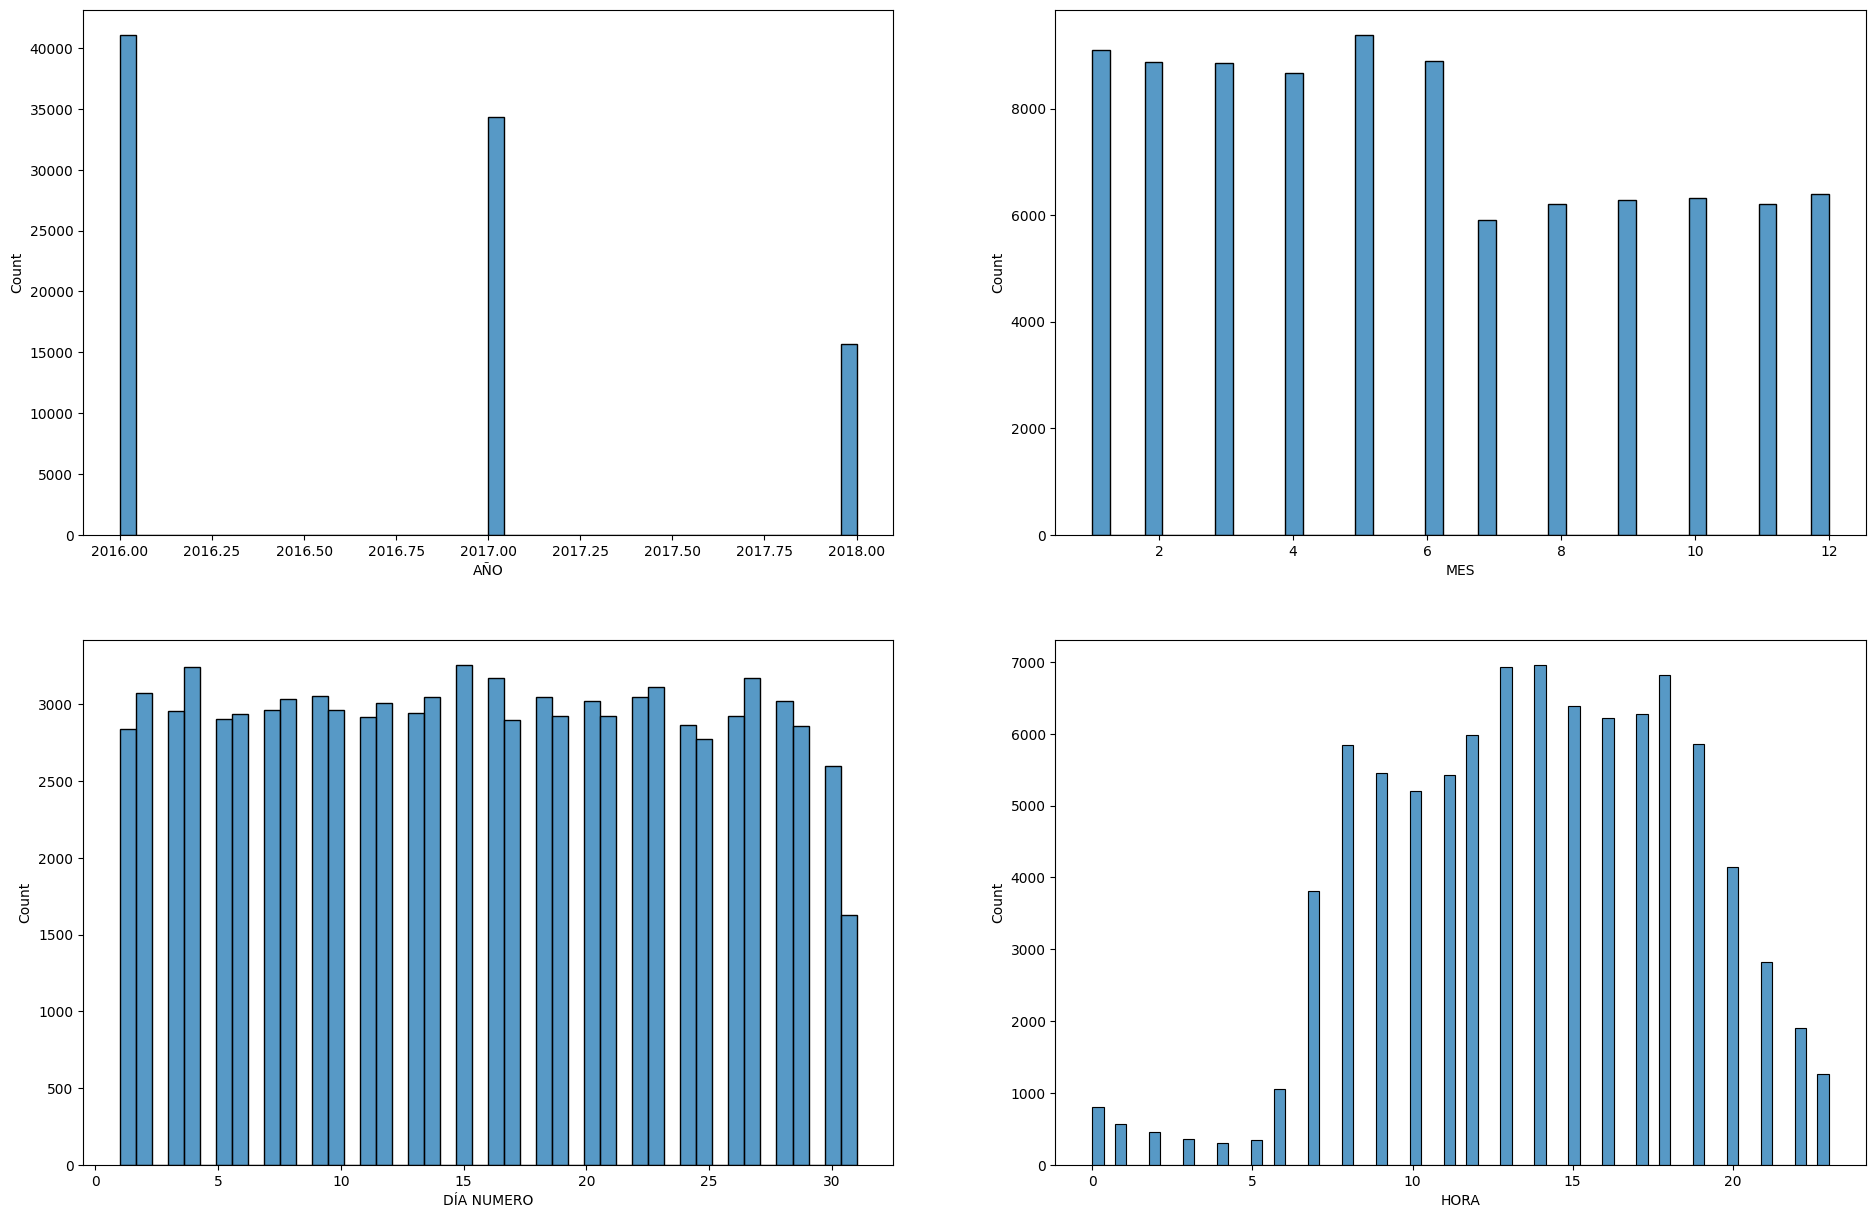

In [51]:
# Creamos un subdataset con las columnas numericas que nos interesan
data = data_datlas[['AÑO', 'MES', 'DÍA NUMERO', 'HORA']]

## Grafica de Distribuciones y Frecuencias
fig, axes = plt.subplots(2, 2, figsize=(23,15))
i, j= (0, 0)
for col in data.columns:
  # Generamos un histograma por cada columna
  sns.histplot(data=data[col], ax=axes[i,j])
  j += 1
  if j == 2:
    i += 1
    j = 0

In [52]:
def top_10_valores(data, columna):
    # Top 10 de valores
    top_10 = data[columna].value_counts().head(10)
    
    # Crea una figura y un conjunto de eje 
    fig, ax = plt.subplots()
    
    # Trama el gráfico de barras
    top_10.plot(kind='bar', ax=ax)
    
    # Personaliza el gráfica
    ax.set_xlabel(columna)
    ax.set_ylabel('Conteo')
    ax.set_title(f'Top de valores de {columna}')
    
    # Muestra el gráfico
    plt.show()

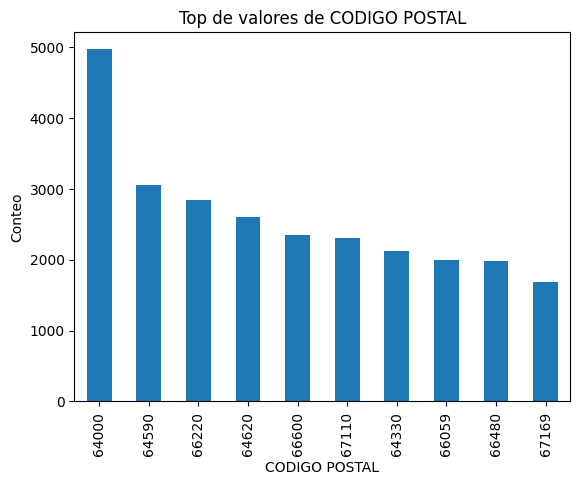

In [53]:
top_10_valores(data_datlas, 'CODIGO POSTAL')

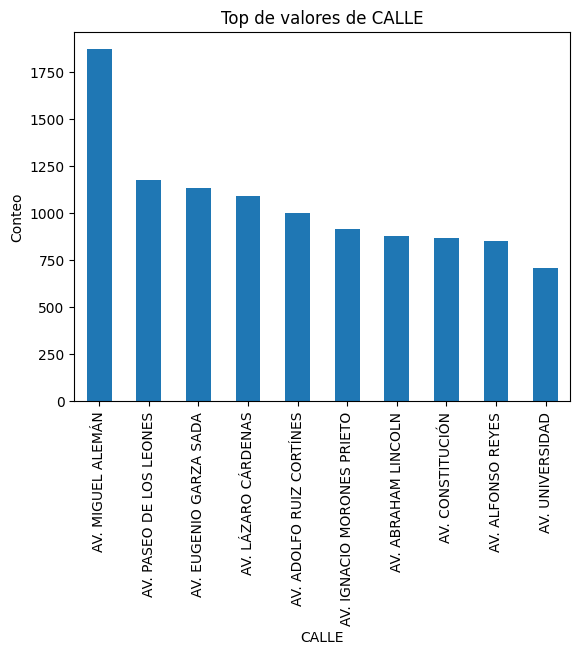

In [54]:
top_10_valores(data_datlas, 'CALLE')

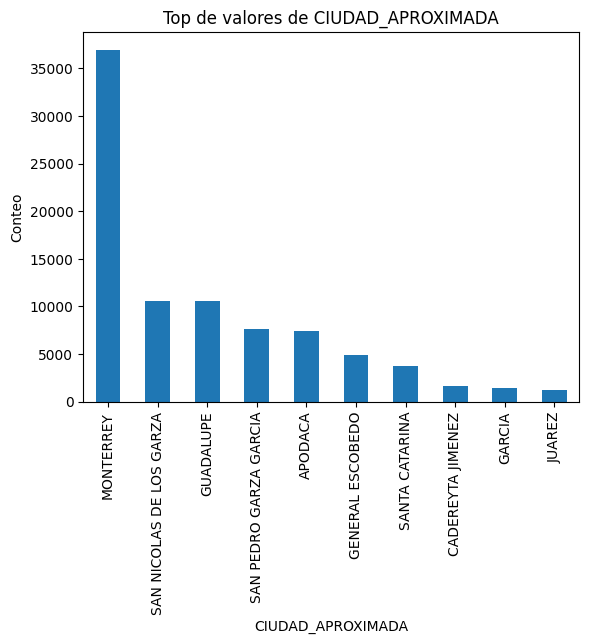

In [55]:
top_10_valores(data_datlas, 'CIUDAD_APROXIMADA')

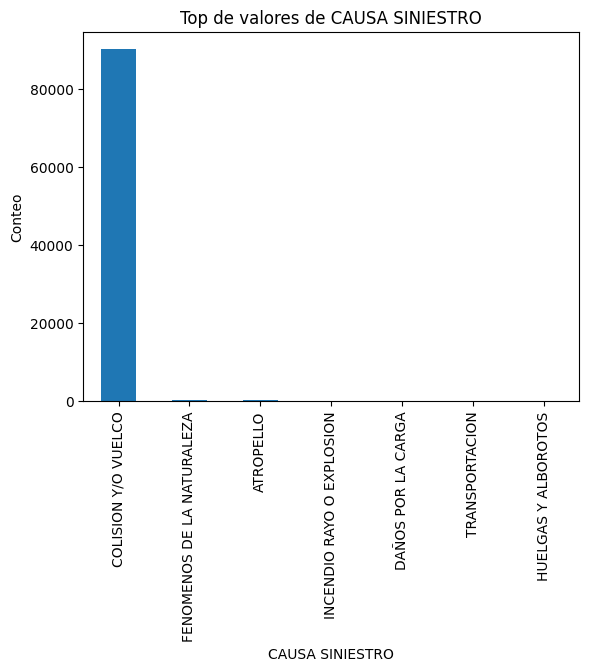

In [56]:
top_10_valores(data_datlas, 'CAUSA SINIESTRO')

In [57]:
# Calcular el procentaje de siniestro x COLISION
print('Porcentaje siniestros x COLISION:', len(data_datlas[data_datlas['CAUSA SINIESTRO'] == 'COLISION Y/O VUELCO'])/len(data_datlas['CAUSA SINIESTRO']))

Porcentaje siniestros x COLISION: 0.9897637881663686


Como el 98.97% de tipo de siniestros es COLISION Y/O VUELCO, podriamos eliminar está columna, ya que no no aporta más información relevante.

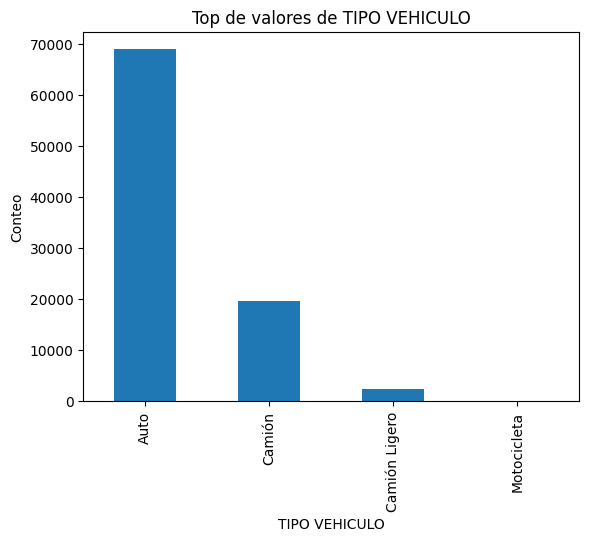

In [58]:
top_10_valores(data_datlas, 'TIPO VEHICULO')

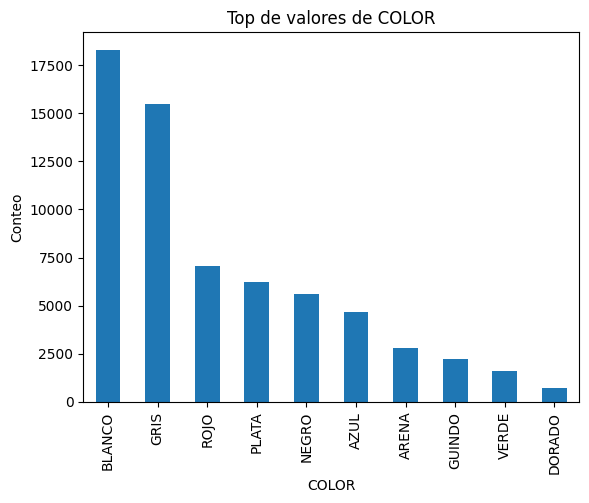

In [59]:
top_10_valores(data_datlas[data_datlas['TIPO VEHICULO'] == 'Auto'], 'COLOR')

In [60]:
data_datlas.columns

Index(['LAT', 'LONG', 'CODIGO POSTAL', 'CALLE', 'COLONIA', 'CAUSA SINIESTRO',
       'TIPO VEHICULO', 'COLOR', 'MODELO_VEHICULO', 'NIVEL DAÑO VEHICULO',
       'PUNTO DE IMPACTO', 'AÑO', 'MES', 'DÍA NUMERO', 'DIA', 'HORA',
       'CIUDAD_APROXIMADA', 'DATE'],
      dtype='object')

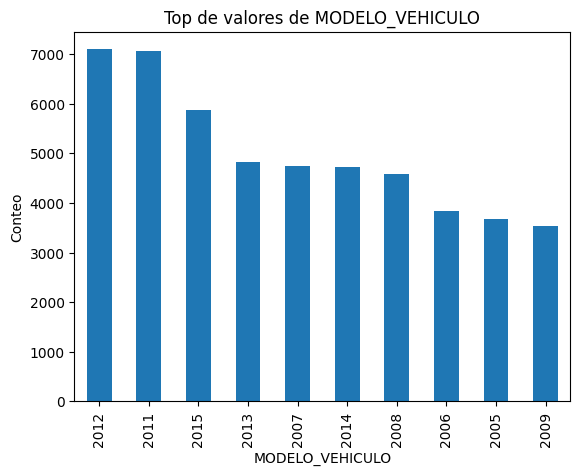

In [61]:
top_10_valores(data_datlas, 'MODELO_VEHICULO')

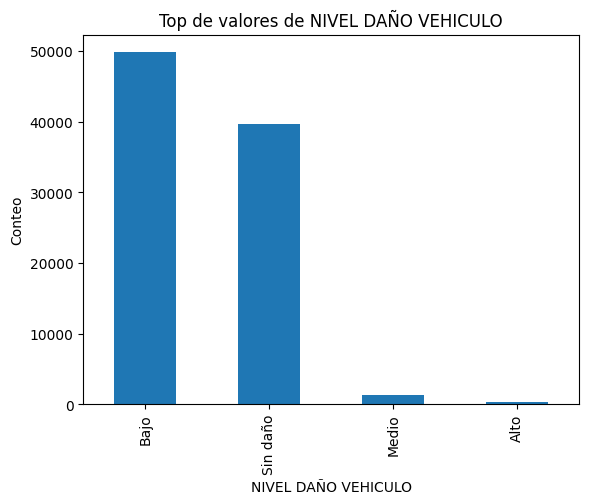

In [62]:
top_10_valores(data_datlas, 'NIVEL DAÑO VEHICULO')

El **nivel de daño** puede ser importante para una aseguradora, ya que entre mayor es el daño, mayor puede ser el costo que debe atender.

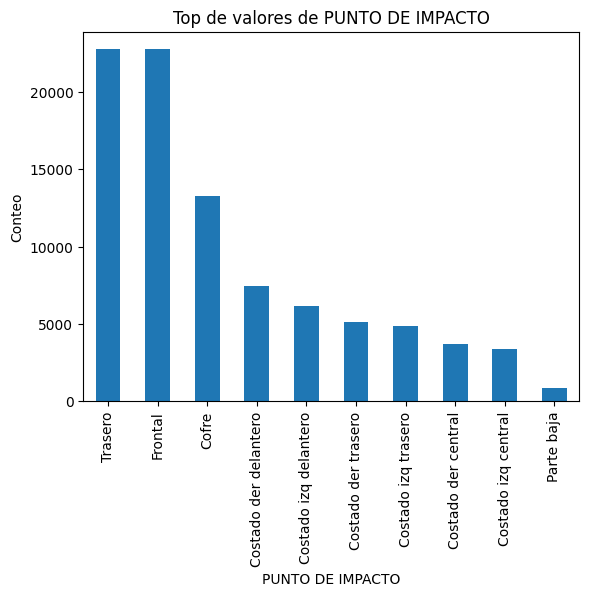

In [63]:
top_10_valores(data_datlas, 'PUNTO DE IMPACTO')

El punto de impacto es información que en principio no genera mucho valor, así que podemos eliminarla.

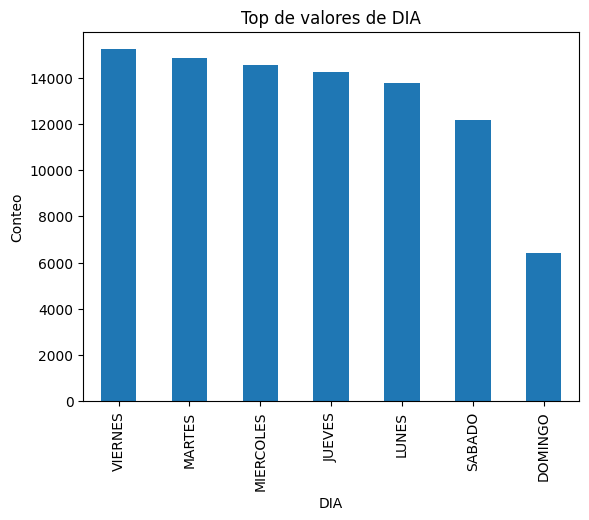

In [64]:
top_10_valores(data_datlas, 'DIA')

In [65]:
## Hagamos un dataframe con los datos de siniestros por fecha
serie_siniestros = pd.DataFrame({'Fecha': sorted(data_datlas['DATE'].unique()), 'Siniestros':data_datlas['DATE'].value_counts().sort_index()})
serie_siniestros.reset_index(drop=True, inplace=True)
serie_siniestros = serie_siniestros.set_index('Fecha')
serie_siniestros

,Siniestros
Fecha,
2016-01-01,50
2016-01-02,54
2016-01-03,60
2016-01-04,94
2016-01-05,94
...,...
2018-06-26,80
2018-06-27,94
2018-06-28,98


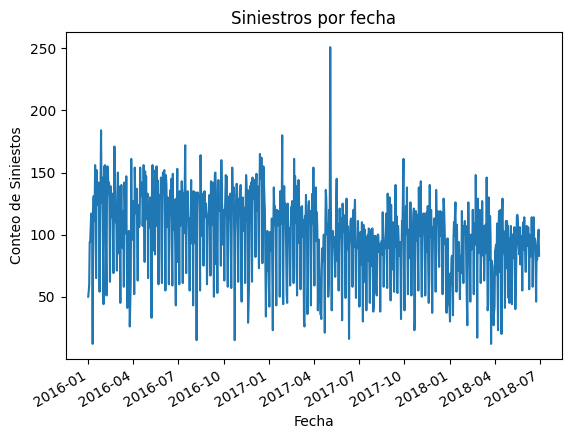

In [66]:
# Gráfico de series de tiempo sobre los choques
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Graficar la serie de tiempo
ax.plot(sorted(data_datlas['DATE'].unique()), data_datlas['DATE'].value_counts().sort_index())

# Personalizar el gráfico
ax.set_xlabel('Fecha')
ax.set_ylabel('Conteo de Siniestos')
ax.set_title('Siniestros por fecha')

# Rotar las etiquetas del eje x para que se vea bien
fig.autofmt_xdate()

# Mostrar el gráfico
plt.show()

In [67]:
# Mostramos un mapa con una muestra de datos
df = data_datlas.iloc[:100]

# Coordenadas del centro del mapa
latitud_centro = 25.7210
longitud_centro = -100.2874

# Crear un mapa
mapa = folium.Map(location=[latitud_centro, longitud_centro], zoom_start=11)

# Agregar marcadores para cada punto en el DataFrame
for index, row in df.iterrows():
    folium.Marker([row['LAT'], row['LONG']]).add_to(mapa)

# Mostrar el mapa
mapa


In [68]:
from folium import plugins

# Coordenadas del centro del mapa
latitud_centro = 25.7210
longitud_centro = -100.2874

# Crear un mapa
mapa = folium.Map(location=[latitud_centro, longitud_centro], zoom_start=11)

# Crear una lista de tuplas de coordenadas (latitud, longitud)
coordenadas = np.array(df[['LAT', 'LONG']])


# Crear una capa de mapa de calor
mapa_calor = plugins.HeatMap(coordenadas)

# Agregar la capa de mapa de calor al mapa
mapa.add_child(mapa_calor)

# Mostrar el mapa
mapa

### **Correlaciones**

In [69]:
## Creamos un pequeño dataset para buscar correlaciones
fechas=sorted(data_datlas['DATE'].unique())
valores=data_datlas['DATE'].value_counts().sort_index()

no_siniestros = pd.DataFrame({'No. Siniestros':valores})
no_siniestros

,No. Siniestros
DATE,
2016-01-01,50
2016-01-02,54
2016-01-03,60
2016-01-04,94
2016-01-05,94
...,...
2018-06-26,80
2018-06-27,94
2018-06-28,98


In [70]:
# Cambiamos el indice por la fecha para hacer un merge con el dataset siniestros
data_clima = data_clima.set_index('Date')
data_clima

,Celsius
Date,
2016-01-05,10.000000
2016-01-08,20.000000
2016-01-09,18.888889
2016-01-10,13.333333
2016-01-11,11.111111
...,...
2018-06-25,28.888889
2018-06-26,25.555556
2018-06-27,28.333333


In [71]:
# Unimos ambos datasets para buscar correlaciones
df_siniestros_clima = pd.merge(no_siniestros, data_clima, left_index=True, right_index=True)
df_siniestros_clima

,No. Siniestros,Celsius
2016-01-05,94,10.000000
2016-01-08,117,20.000000
2016-01-09,100,18.888889
2016-01-10,12,13.333333
2016-01-11,120,11.111111
...,...,...
2018-06-25,91,28.888889
2018-06-26,80,25.555556
2018-06-27,94,28.333333
2018-06-28,98,29.444444


<Figure size 640x480 with 0 Axes>

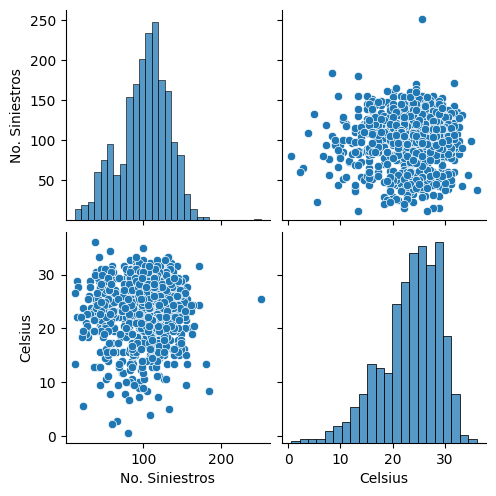

Celsius           1.000000
No. Siniestros    0.030192
Name: Celsius, dtype: float64

In [72]:
## Correlacion entre temperatura y numero de siniestros
plt.figure()
ax = sns.pairplot(df_siniestros_clima)
plt.show()
# Correlacion en numero
corr_matrix_pearson = df_siniestros_clima.corr(method='pearson')
corr_matrix_pearson['Celsius'].sort_values(ascending=False)

<Figure size 640x480 with 0 Axes>

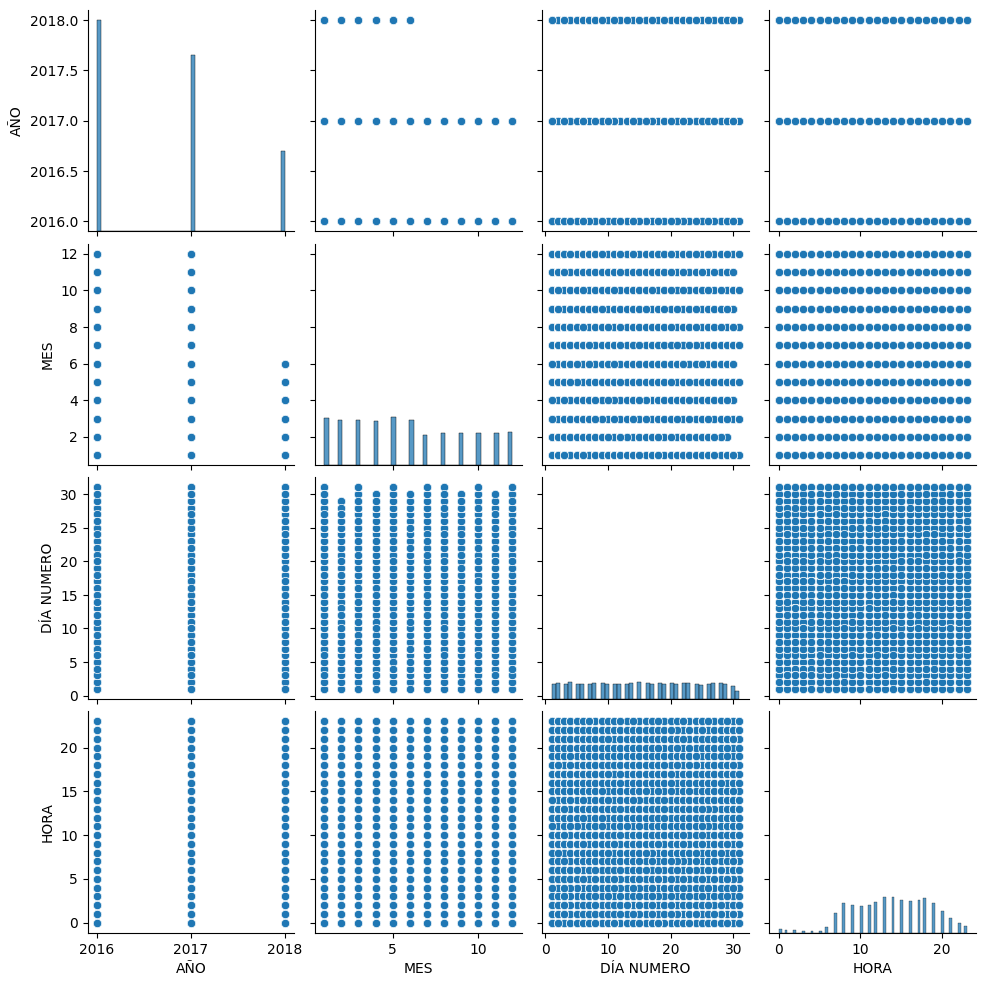

AÑO           1.000000
DÍA NUMERO    0.004032
HORA          0.003119
MES          -0.266936
Name: AÑO, dtype: float64

In [73]:
## Vamos a buscar correlaciones en el dataset que contiene el AÑO, MES, DIA NUMERO y HORA
plt.figure()
ax = sns.pairplot(data)
plt.show()
# Correlacion en numero
corr_matrix_pearson = data.corr(method='pearson')
corr_matrix_pearson['AÑO'].sort_values(ascending=False)

En la gráfica anterior no encontramos correlación, esto debe ser porque son formatos de tiempo en diferentes métricas, para buscar mejores correlaciones podriamos intentar hacer One-Hot Encoding o get_dummies y hacer nuevas correlaciones, pero este proceso puede alargar el proyecto, por lo que solo lo haré si me queda tiempo.

# 3. Generación de Hipotesis y Validación

### **Supuestos**

El plantearnos un supuesto y validarlo nos permite mejorar la precisión en la toma de decisiones, es por ello, que aquí me haré dos supuestos:

1. Los autos blancos son más propensos a chocar.
2. Podemos predecir cuantos choques habrá en el futuro.

**Validación del Primer Supuesto**

In [74]:
data_s1 = data_datlas[data_datlas['TIPO VEHICULO'] == 'Auto']
data_s1 = data_s1[data_s1['COLOR'] == 'BLANCO']
proporcion_s1 = data_s1.shape[0]/data_datlas.shape[0]
print('Proporcion de autos blancos:', proporcion_s1)

Proporcion de autos blancos: 0.20069777392563662


In [75]:
stats.binomtest(3, n=15, p=0.1, alternative='greater').pvalue

0.18406106910639122

In [76]:
# Realizar una prueba de proporciones
umbral = 0.5 # hago una selección subjetiva donde considero que la mayoría es por encima del 50%
# Utilizo el test binomial porque se basa en el experimento bernoulli, donde son puede ser choque con auto blanco o no
p_valor = stats.binomtest(data_s1.shape[0], data_datlas.shape[0], umbral).pvalue

nivel_significancia = 0.05

# Imprimir los resultados
if p_valor > nivel_significancia:
    print("La mayoría de los choques en la ciudad son hechos con autos blancos.")
else:
    print("No hay suficiente evidencia para afirmar que la mayoría de los choques en la ciudad son hechos con autos blancos")


No hay suficiente evidencia para afirmar que la mayoría de los choques en la ciudad son hechos con autos blancos


**Validación del Segundo Supuesto**

In [77]:
## Para validar el segundo supuesto necesito crear un modelo predictivo
## Para ello voy a utilizar un modelo de xgboost
choques = no_siniestros.copy()
choques

,No. Siniestros
DATE,
2016-01-01,50
2016-01-02,54
2016-01-03,60
2016-01-04,94
2016-01-05,94
...,...
2018-06-26,80
2018-06-27,94
2018-06-28,98


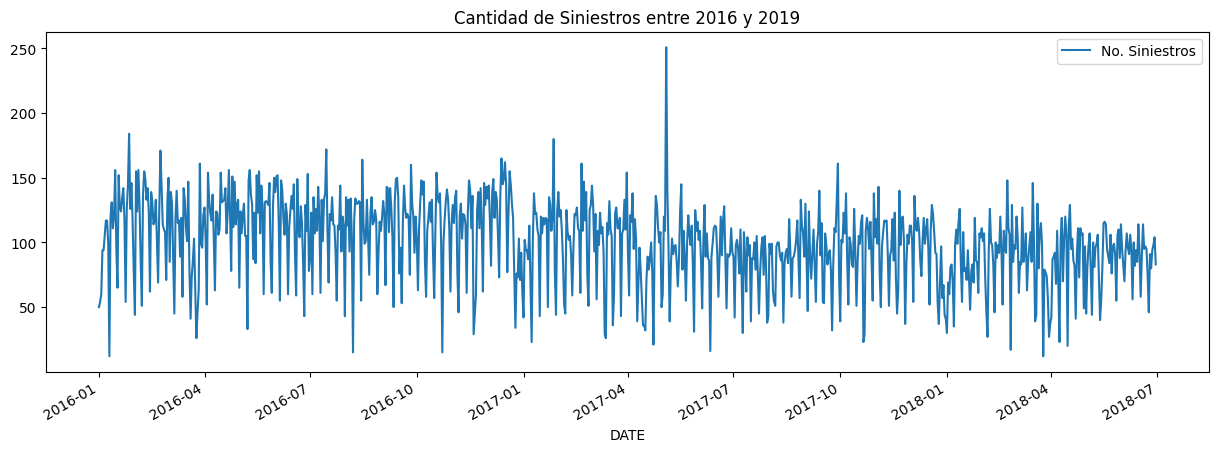

In [78]:
## Ploteamos la serie de tiempo
choques.plot(style='-', figsize=(15,5), title='Cantidad de Siniestros entre 2016 y 2019')
plt.show()

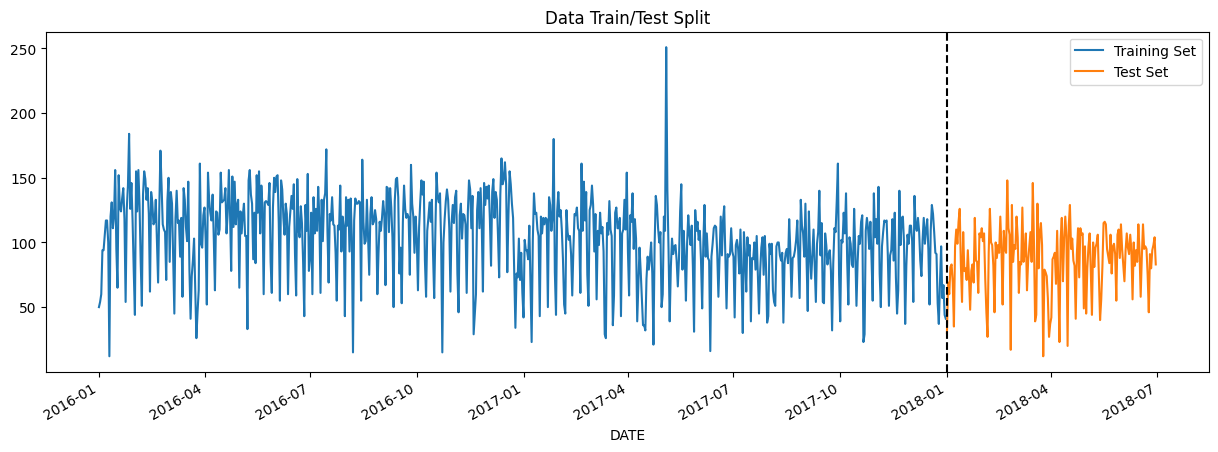

In [79]:
## Ploteamos como se verian los conjuntos de entrenamiento y prueba
train = choques.loc[choques.index < '01-01-2018']
test = choques.loc[choques.index >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [80]:
## Funcion para crear las variales de entrenamiento y prueba basandose en el indice de fecha
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [81]:
## Creamos las variables
choques = create_features(choques)
choques

,No. Siniestros,dayofweek,quarter,month,year,dayofyear
DATE,,,,,,
2016-01-01,50,4,1,1,2016,1
2016-01-02,54,5,1,1,2016,2
2016-01-03,60,6,1,1,2016,3
2016-01-04,94,0,1,1,2016,4
2016-01-05,94,1,1,1,2016,5
...,...,...,...,...,...,...
2018-06-26,80,1,2,6,2018,177
2018-06-27,94,2,2,6,2018,178
2018-06-28,98,3,2,6,2018,179


In [82]:
## Ahora creamos el modelo
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'No. Siniestros'

In [83]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [84]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01)

reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:106.82982	validation_1-rmse:89.21283
[100]	validation_0-rmse:43.40523	validation_1-rmse:32.81761
[200]	validation_0-rmse:22.58807	validation_1-rmse:20.73334
[265]	validation_0-rmse:17.66918	validation_1-rmse:21.20959


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [85]:
## feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance'])

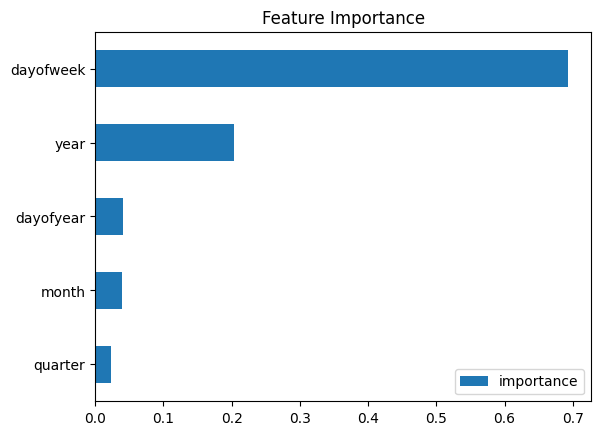

In [86]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [87]:
## Predecimos y agregamos la columna en el dataset de choques
test['prediction'] = reg.predict(X_test)
choques = choques.merge(test[['prediction']], how='left', left_index=True, right_index=True)

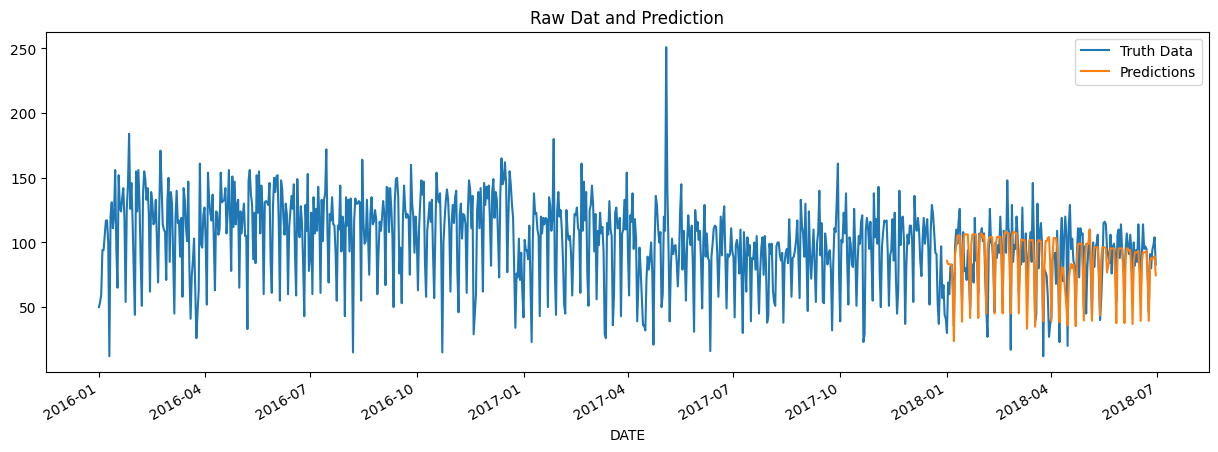

In [88]:
## Graficamos los resultados
ax = choques[['No. Siniestros']].plot(figsize=(15,5))
choques['prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [89]:
## Evaluacion del modelo
score = np.sqrt(mean_squared_error(test['No. Siniestros'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 20.64


In [90]:
## Validamos el supuesto que nos hicimos

# Realizar una prueba estadística (por ejemplo, prueba t de Student)
resultado, p_valor = stats.ttest_rel(test['No. Siniestros'], test['prediction'])

# umbral de probabilidad de rechazar incorrectamente la hipotesis nula (5%)
nivel_significancia = 0.05

# Imprimir el resultado de la prueba estadística
# Usamos el t-test porque tenemos dos muestras de datos y queremos comparar si son significativamente identicos.
if p_valor > nivel_significancia:
    print("La proyección es significativamente parecida de los datos reales.")
else:
    print("No hay evidencia suficiente para afirmar que la proyección es parecida de los datos reales.")


La proyección es significativamente parecida de los datos reales.


Con lo anterior validamos el supuesto de que podemos predecir el número de siniestros en un día del futuro, sin embargo, es importante mencionar que en la vida real la precisión puede varias mucho por diferentes variables, por ejemplo, cambios en el entorn como la infraestructura vial, políticas gubernamentales, condiciones económicas, inclusive factores como clima de una ciudad.

Exportamos un archivo csv para ser tratado en una herramienta de **Business Intelligence**.

In [91]:
data_datlas.head(3)

,LAT,LONG,CODIGO POSTAL,CALLE,COLONIA,CAUSA SINIESTRO,TIPO VEHICULO,COLOR,MODELO_VEHICULO,NIVEL DAÑO VEHICULO,PUNTO DE IMPACTO,AÑO,MES,DÍA NUMERO,DIA,HORA,CIUDAD_APROXIMADA,DATE
0,25.647351,-100.140132,67277,AMERICA 65,BALCONES DE ZINDARO,COLISION Y/O VUELCO,Camión,BLANCO,2009,Sin daño,Costado izq trasero,2018,1,25,JUEVES,10,JUAREZ,2018-01-25
1,25.718027,-100.249990,66480,AV. CONDUCTORES,CONDUCTORES INFONAVIT,COLISION Y/O VUELCO,Auto,GRIS,2016,Sin daño,Frontal,2018,1,19,VIERNES,9,SAN NICOLAS DE LOS GARZA,2018-01-19
2,25.723590,-100.198780,67117,BOULEVARD ACAPULCO,REAL DE SAN MIGUEL,COLISION Y/O VUELCO,Auto,BLANCO,2000,Sin daño,Frontal,2018,1,29,LUNES,17,GUADALUPE,2018-01-29


In [92]:
data_datlas.to_csv('../data/data_datlas_cleaned.csv')

# 4. Preparación para un Deployment

In [93]:
## Exportamos el modelo
import pickle

# Guardar el modelo entrenado en un archivo pkl
with open('modelo.pkl', 'wb') as file:
    pickle.dump(reg, file)


In [94]:
da=pd.DataFrame(X_test.iloc[0]).T
da

,dayofweek,quarter,month,year,dayofyear
2018-01-01,0,1,1,2018,1


In [114]:
df2 = pd.DataFrame(np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]]),
                    columns=['a', 'b', 'c'])
df2

,a,b,c
0,1,2,3
1,4,5,6
2,7,8,9


In [125]:
data = pd.DataFrame(np.array([[0.0], [1.0], [1.0], [2018], [1.0]])).T.set_axis(['dayofweek', 'quarter', 'month', 'year', 'dayofyear'], axis=1)

In [127]:
reg.predict(data)[0]

85.7883

In [100]:
pd.DataFrame(X_test.iloc[0]).T

,dayofweek,quarter,month,year,dayofyear
2018-01-01,0,1,1,2018,1


In [99]:
reg.predict(pd.DataFrame(X_test.iloc[0]).T)

array([85.7883], dtype=float32)